In [1]:
import numpy as np
from keras import layers, models, optimizers
from keras.models import Model
from keras.layers import Input, Reshape, Flatten, Conv2D, BatchNormalization, concatenate, Dropout, Lambda, Dense
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
import os
import datetime
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import argparse
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
import cv2

def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)
    
#     output = layers.Conv2D(filters=8*32, kernel_size=9, strides=2, padding='valid',
#                            name='primarycap_conv2d')(conv1)
    
    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    return train_model, eval_model, manipulate_model


Using TensorFlow backend.


In [2]:
csv_data = pd.read_csv('AND_Features.csv')
display(csv_data.head()), display(csv_data.shape)
image_path = 'cleaned_AND_data_64x64/'
images = os.listdir(image_path)
print(len(images))
images = pd.DataFrame(np.array(images), columns=['image'])
print(images.shape)

,Unnamed: 0,ImageId,f1,f2,f3,f4,f5,f6,f7,f8,f9
0,0,0359a,2,1,1,0,2,2,0,2,2
1,1,0577a,2,1,1,0,2,2,0,1,2
2,2,1120a,2,1,1,3,2,2,0,2,2
3,3,1120b,1,1,1,0,2,2,0,2,2
4,4,1120c,2,1,1,0,2,2,0,0,2


(1026, 11)

13850
(13850, 1)


In [3]:
dataset_columns = csv_data.columns
display(csv_data.head(20))
csv_data.shape

,Unnamed: 0,ImageId,f1,f2,f3,f4,f5,f6,f7,f8,f9
0,0,0359a,2,1,1,0,2,2,0,2,2
1,1,0577a,2,1,1,0,2,2,0,1,2
2,2,1120a,2,1,1,3,2,2,0,2,2
3,3,1120b,1,1,1,0,2,2,0,2,2
4,4,1120c,2,1,1,0,2,2,0,0,2
5,5,1121a,2,1,1,3,2,2,0,1,2
6,6,1121b,2,1,1,0,2,2,0,3,2
7,7,1121c,1,1,1,0,2,2,0,1,2
8,8,1229b,1,1,1,3,2,2,0,2,2
9,9,1302a,2,1,1,3,2,2,0,0,2


(1026, 11)

In [4]:
train_csv_data =  csv_data[:700]
val_csv_data =  csv_data[700:]
train_csv_data.shape, val_csv_data.shape

((700, 11), (326, 11))

In [5]:
feature_lengths = {}
for col in dataset_columns[2:10]:
    feature_lengths[col] = len(csv_data[col].unique())
feature_lengths

{'f1': 4, 'f2': 5, 'f3': 3, 'f4': 5, 'f5': 4, 'f6': 4, 'f7': 4, 'f8': 5}

In [6]:
f = []
for col in dataset_columns[2:]:
    f.append(csv_data[col].unique().shape[0])
f

[4, 5, 3, 5, 4, 4, 4, 5, 2]

In [7]:
input_shape = (64,64,1)
inp = Input(shape=input_shape)
bm = Conv2D(kernel_size=(3,3), filters=32, activation='relu', strides=(1,1), padding='same')(inp)
bm = Conv2D(kernel_size=(3,3), filters=64, activation='relu', strides=(2,2), padding='same')(bm)
bm = Dropout(0.5)(bm)
bm = Conv2D(kernel_size=(3,3), filters=128, activation='relu', strides=(1,1), padding='same')(bm)
bm_out = Conv2D(kernel_size=(3,3), filters=256, activation='relu', strides=(2,2), padding='same', name='basemodel_output')(bm)
baseModel = Model(inputs=[inp],outputs=[bm_out])
baseModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
basemodel_output (Conv2D)    (None, 16, 16, 256)       295168    
Total params: 387,840
Trainable params: 387,840
Non-trainable params: 0
_________________________________________________________________


In [8]:
def getdigit(x, f):
#     print(x[:,f].shape)
    return x[:,f]


In [9]:
n_class = 8
routings = 3
x = baseModel.get_layer('basemodel_output').output
# x = layers.Input(shape=input_shape)

# Layer 1: Just a conventional Conv2D layer
# conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

#     output = layers.Conv2D(filters=8*32, kernel_size=9, strides=2, padding='valid',
#                            name='primarycap_conv2d')(conv1)

# Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
primarycaps = PrimaryCap(x, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

# Layer 3: Capsule layer. Routing algorithm works here.
digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                         name='digitcaps')(primarycaps)

# Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
# If using tensorflow, this will not be necessary. :)
# out_caps = Length(name='capsnet')(digitcaps)
# f=0
l1 = Lambda(getdigit,arguments={'f':0})(digitcaps)
l2 = Lambda(function=getdigit, arguments={'f':1})(digitcaps)
l3 = Lambda(function=getdigit, arguments={'f':2})(digitcaps)
l4 = Lambda(function=getdigit, arguments={'f':3})(digitcaps)
l5 = Lambda(function=getdigit, arguments={'f':4})(digitcaps)
l6 = Lambda(function=getdigit, arguments={'f':5})(digitcaps)
l7 = Lambda(function=getdigit, arguments={'f':6})(digitcaps)
l8 = Lambda(function=getdigit, arguments={'f':7})(digitcaps)

dense_layer_1 = Dense(64 , activation='relu', name = 'dense_layer_1')(l1)
dense_layer_2 = Dense(64 , activation='relu', name = 'dense_layer_2')(l2)
dense_layer_3 = Dense(64 , activation='relu', name = 'dense_layer_3')(l3)
dense_layer_4 = Dense(64 , activation='relu', name = 'dense_layer_4')(l4)
dense_layer_5 = Dense(64 , activation='relu', name = 'dense_layer_5')(l5)
dense_layer_6 = Dense(64 , activation='relu', name = 'dense_layer_6')(l6)
dense_layer_7 = Dense(64 , activation='relu', name = 'dense_layer_7')(l7)
dense_layer_8 = Dense(64 , activation='relu', name = 'dense_layer_8')(l8)


out_feature_1 = Dense(f[0] , activation='softmax', name = 'out_feature_1')(dense_layer_1)
out_feature_2 = Dense(f[1] , activation='softmax', name = 'out_feature_2')(dense_layer_2)
out_feature_3 = Dense(f[2] , activation='softmax', name = 'out_feature_3')(dense_layer_3)
out_feature_4 = Dense(f[3] , activation='softmax', name = 'out_feature_4')(dense_layer_4)
out_feature_5 = Dense(f[4] , activation='softmax', name = 'out_feature_5')(dense_layer_5)
out_feature_6 = Dense(f[5] , activation='softmax', name = 'out_feature_6')(dense_layer_6)
out_feature_7 = Dense(f[6] , activation='softmax', name = 'out_feature_7')(dense_layer_7)
out_feature_8 = Dense(f[7] , activation='softmax', name = 'out_feature_8')(dense_layer_8)

decoder = Flatten()(digitcaps)
decoder = Dense(512, activation='relu')(decoder)
decoder = Dense(1024, activation='relu')(decoder)
decoder = Dense(np.prod(input_shape), activation='sigmoid')(decoder)
decoder_out = Reshape(target_shape = input_shape, name = 'recon')(decoder)


Instructions for updating:
dim is deprecated, use axis instead


In [10]:
model = Model(inputs=baseModel.inputs,outputs=[decoder_out
                                            ,out_feature_1
                                               ,out_feature_2
                                               ,out_feature_3
                                               ,out_feature_4
                                               ,out_feature_5
                                               ,out_feature_6
                                               ,out_feature_7
                                               ,out_feature_8])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

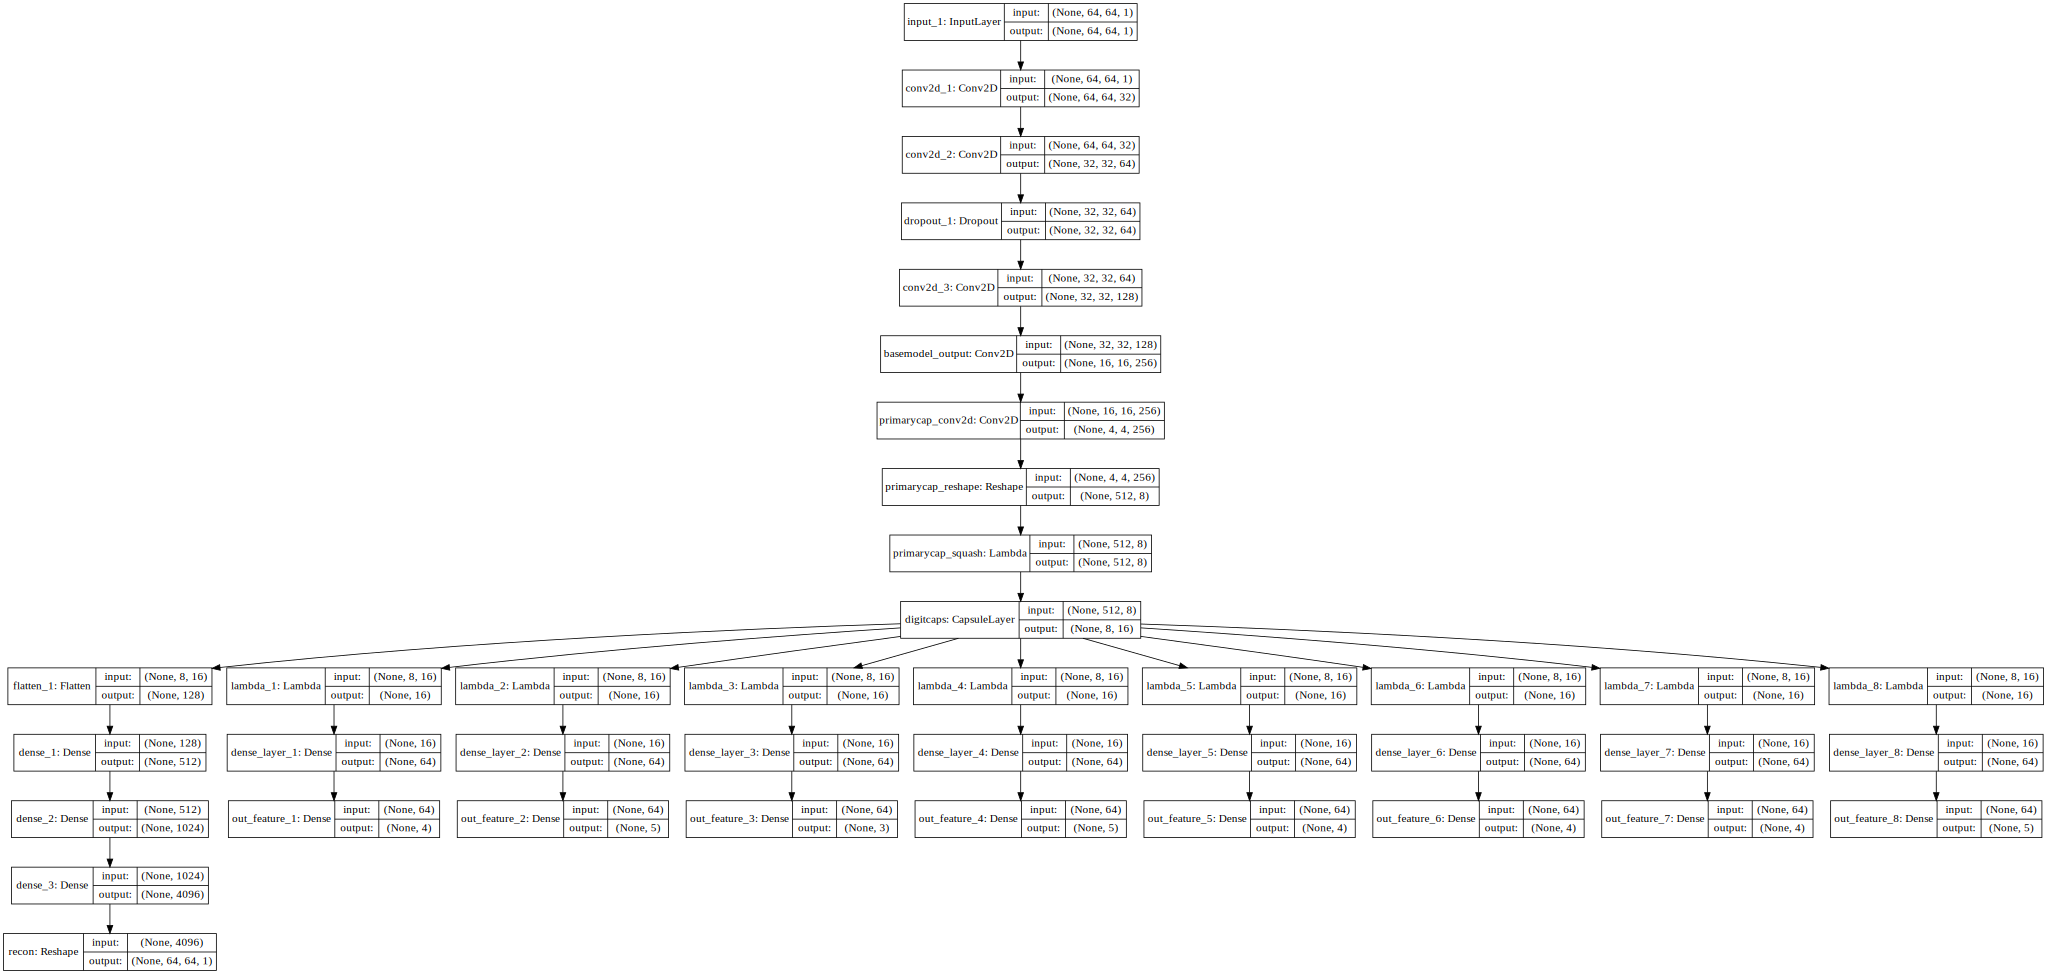

In [11]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [12]:
losses = {}
lossWeights = {}
for i in range(1,9):
    losses["out_feature_"+str(i)] = "categorical_crossentropy"
    lossWeights["out_feature_"+str(i)] = 1.0
losses['recon'] = 'mse'
lossWeights['recon'] = 1.0

In [13]:
INIT_LR = 0.001
# opt = optimizers.SGD(lr=INIT_LR, decay=1e-6, momentum=0.95, nesterov=True)
# opt = optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
opt = optimizers.Adadelta(lr=INIT_LR, decay=1e-04)
model.compile(optimizer=opt
                  ,loss=losses
                  ,loss_weights=lossWeights
                  ,metrics=['accuracy'])


In [14]:

def datagen(batch_size,list_of_writers):
    counter = 0
    
    
    while counter <= batch_size:
        counter = 0
        # for writer in unique_writers:
        #     print(identitycounter*100/stop_at, end='\r')
        writer_indexes = np.random.randint(0,len(list_of_writers),batch_size)
        x,f_1_out,f_2_out,f_3_out,f_4_out,f_5_out,f_6_out,f_7_out,f_8_out = [],[],[],[],[],[],[],[],[]
        for writer_index in writer_indexes:
#             class_vectors = []
            writer = list_of_writers[writer_index]
#             print(writer)
            writer_samples = list(images[images['image'].str.match(writer)]['image'])
#             print('writer:',writer,', writer_samples:',writer_samples)
            if len(writer_samples) == 0:
                continue
            writer_sample_index = np.random.randint(0,len(writer_samples))

            #     unique_writers_count[writer] = len(writer_samples)
#             print('writer_sample_index:',writer_sample_index)
            csv_writer = writer_samples[writer_sample_index][:5]

    
            loaded_image = cv2.imread(os.path.join(image_path,writer_samples[writer_sample_index]),0)
            loaded_image = np.expand_dims(loaded_image,-1)
#             print('csv_writer:', csv_writer, ', writer:', writer)
#             display(csv_data[csv_data['ImageId'].str.match(csv_writer)])
            csv_discreete_features = csv_data[csv_data['ImageId'].str.match(csv_writer)].iloc[0].values[2:]
#             print(csv_writer, writer_samples[writer_sample_index])
#             print(csv_writer,csv_discreete_features)
#             for i in range(1,9):
#                 print(csv_discreete_features[i-1],end=',')
            f_1_out.append(csv_discreete_features[0])
            f_2_out.append(csv_discreete_features[1])
            f_3_out.append(csv_discreete_features[2])
            f_4_out.append(csv_discreete_features[3])
            f_5_out.append(csv_discreete_features[4])
            f_6_out.append(csv_discreete_features[5])
            f_7_out.append(csv_discreete_features[6])
            f_8_out.append(csv_discreete_features[7])
#                 class_vectors.append(to_categorical(csv_discreete_features[i-1],num_classes=feature_lengths['f'+str(i)]))
#             print("\n",len(class_vectors))
#             print('\n-----------')
            
#             print("++++++++++++++++++++++[",counter,"]+++++++++++++++++++++++")
        #     imgcounter = 0
        #     for sample in writer_samples:
        #         imagepath = os.path.join(image_path,sample)
        #         raw_img = cv2.imread(imagepath)
        #         imgcounter+=1
        #     imgcounter=0
        #     identitycounter += 1
            x.append(255.0-loaded_image)
            
            
            counter+=1
#             print('counter:', counter, end='\r')
        yield np.array(x)/255.0, [np.array(x)/255.0 \
                                  ,to_categorical(f_1_out,num_classes=feature_lengths['f1']) \
                            , to_categorical(f_2_out,num_classes=feature_lengths['f2']) \
                            , to_categorical(f_3_out,num_classes=feature_lengths['f3']) \
                            , to_categorical(f_4_out,num_classes=feature_lengths['f4']) \
                            , to_categorical(f_5_out,num_classes=feature_lengths['f5']) \
                            , to_categorical(f_6_out,num_classes=feature_lengths['f6']) \
                            , to_categorical(f_7_out,num_classes=feature_lengths['f7']) \
                            , to_categorical(f_8_out,num_classes=feature_lengths['f8'])]
                    

In [15]:
# # unique_writers_count
# f_count = {}
train_list_of_writers = train_csv_data['ImageId'].unique()
val_list_of_writers = val_csv_data['ImageId'].unique()
batch_size = 64

tg = datagen(batch_size,train_list_of_writers)
vg = datagen(batch_size,val_list_of_writers)


In [16]:
inputs,o = next(tg)
inputs.shape, o[0].shape, o[1].shape,o[2].shape,o[3].shape,o[4].shape,o[5].shape,o[6].shape,o[7].shape, o[8].shape

((64, 64, 64, 1),
 (64, 64, 64, 1),
 (64, 4),
 (64, 5),
 (64, 3),
 (64, 5),
 (64, 4),
 (64, 4),
 (64, 4),
 (64, 5))

In [17]:
EPOCHS = 10000

datetime = str(datetime.datetime.now())
LOG_DIR = 'training/unseen_speakers/logs/'
run_name = datetime.replace(' ','_').replace('.','_')
print('run_name:',run_name)
tb = callbacks.TensorBoard(log_dir=os.path.join(LOG_DIR, run_name),batch_size=16)
mc = callbacks.ModelCheckpoint(filepath='human_features_capsulenets_weights_v1.h5', monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = callbacks.EarlyStopping(patience=1000, monitor='val_loss', min_delta=0.0005, mode='auto')
hist = model.fit_generator(generator=tg
                    ,validation_data=vg
                    ,epochs=EPOCHS
                    , steps_per_epoch=1
                    , validation_steps=1
                    , verbose = 3
                    , callbacks=[tb,mc,es])

run_name: 2019-03-10_19:15:26_770450
Epoch 1/5000

Epoch 00001: val_loss improved from inf to 11.70978, saving model to human_features_capsulenets_weights_v1.h5
Epoch 2/5000

Epoch 00002: val_loss did not improve from 11.70978
Epoch 3/5000

Epoch 00003: val_loss did not improve from 11.70978
Epoch 4/5000

Epoch 00004: val_loss did not improve from 11.70978
Epoch 5/5000

Epoch 00005: val_loss did not improve from 11.70978
Epoch 6/5000

Epoch 00006: val_loss did not improve from 11.70978
Epoch 7/5000

Epoch 00007: val_loss did not improve from 11.70978
Epoch 8/5000

Epoch 00008: val_loss did not improve from 11.70978
Epoch 9/5000

Epoch 00009: val_loss did not improve from 11.70978
Epoch 10/5000

Epoch 00010: val_loss improved from 11.70978 to 11.70977, saving model to human_features_capsulenets_weights_v1.h5
Epoch 11/5000

Epoch 00011: val_loss improved from 11.70977 to 11.70951, saving model to human_features_capsulenets_weights_v1.h5
Epoch 12/5000

Epoch 00012: val_loss did not improv


Epoch 00110: val_loss did not improve from 11.70767
Epoch 111/5000

Epoch 00111: val_loss did not improve from 11.70767
Epoch 112/5000

Epoch 00112: val_loss did not improve from 11.70767
Epoch 113/5000

Epoch 00113: val_loss did not improve from 11.70767
Epoch 114/5000

Epoch 00114: val_loss did not improve from 11.70767
Epoch 115/5000

Epoch 00115: val_loss did not improve from 11.70767
Epoch 116/5000

Epoch 00116: val_loss did not improve from 11.70767
Epoch 117/5000

Epoch 00117: val_loss did not improve from 11.70767
Epoch 118/5000

Epoch 00118: val_loss did not improve from 11.70767
Epoch 119/5000

Epoch 00119: val_loss did not improve from 11.70767
Epoch 120/5000

Epoch 00120: val_loss did not improve from 11.70767
Epoch 121/5000

Epoch 00121: val_loss did not improve from 11.70767
Epoch 122/5000

Epoch 00122: val_loss did not improve from 11.70767
Epoch 123/5000

Epoch 00123: val_loss did not improve from 11.70767
Epoch 124/5000

Epoch 00124: val_loss did not improve from 11.7


Epoch 00226: val_loss did not improve from 11.70588
Epoch 227/5000

Epoch 00227: val_loss did not improve from 11.70588
Epoch 228/5000

Epoch 00228: val_loss did not improve from 11.70588
Epoch 229/5000

Epoch 00229: val_loss did not improve from 11.70588
Epoch 230/5000

Epoch 00230: val_loss did not improve from 11.70588
Epoch 231/5000

Epoch 00231: val_loss improved from 11.70588 to 11.70571, saving model to human_features_capsulenets_weights_v1.h5
Epoch 232/5000

Epoch 00232: val_loss did not improve from 11.70571
Epoch 233/5000

Epoch 00233: val_loss did not improve from 11.70571
Epoch 234/5000

Epoch 00234: val_loss did not improve from 11.70571
Epoch 235/5000

Epoch 00235: val_loss did not improve from 11.70571
Epoch 236/5000

Epoch 00236: val_loss did not improve from 11.70571
Epoch 237/5000

Epoch 00237: val_loss did not improve from 11.70571
Epoch 238/5000

Epoch 00238: val_loss did not improve from 11.70571
Epoch 239/5000

Epoch 00239: val_loss did not improve from 11.70571



Epoch 00342: val_loss did not improve from 11.70359
Epoch 343/5000

Epoch 00343: val_loss improved from 11.70359 to 11.70358, saving model to human_features_capsulenets_weights_v1.h5
Epoch 344/5000

Epoch 00344: val_loss did not improve from 11.70358
Epoch 345/5000

Epoch 00345: val_loss did not improve from 11.70358
Epoch 346/5000

Epoch 00346: val_loss did not improve from 11.70358
Epoch 347/5000

Epoch 00347: val_loss did not improve from 11.70358
Epoch 348/5000

Epoch 00348: val_loss did not improve from 11.70358
Epoch 349/5000

Epoch 00349: val_loss did not improve from 11.70358
Epoch 350/5000

Epoch 00350: val_loss did not improve from 11.70358
Epoch 351/5000

Epoch 00351: val_loss did not improve from 11.70358
Epoch 352/5000

Epoch 00352: val_loss improved from 11.70358 to 11.70309, saving model to human_features_capsulenets_weights_v1.h5
Epoch 353/5000

Epoch 00353: val_loss did not improve from 11.70309
Epoch 354/5000

Epoch 00354: val_loss did not improve from 11.70309
Epoch


Epoch 00457: val_loss improved from 11.70166 to 11.70104, saving model to human_features_capsulenets_weights_v1.h5
Epoch 458/5000

Epoch 00458: val_loss did not improve from 11.70104
Epoch 459/5000

Epoch 00459: val_loss did not improve from 11.70104
Epoch 460/5000

Epoch 00460: val_loss did not improve from 11.70104
Epoch 461/5000

Epoch 00461: val_loss did not improve from 11.70104
Epoch 462/5000

Epoch 00462: val_loss did not improve from 11.70104
Epoch 463/5000

Epoch 00463: val_loss did not improve from 11.70104
Epoch 464/5000

Epoch 00464: val_loss improved from 11.70104 to 11.70098, saving model to human_features_capsulenets_weights_v1.h5
Epoch 465/5000

Epoch 00465: val_loss did not improve from 11.70098
Epoch 466/5000

Epoch 00466: val_loss did not improve from 11.70098
Epoch 467/5000

Epoch 00467: val_loss did not improve from 11.70098
Epoch 468/5000

Epoch 00468: val_loss did not improve from 11.70098
Epoch 469/5000

Epoch 00469: val_loss did not improve from 11.70098
Epoch


Epoch 00571: val_loss did not improve from 11.69787
Epoch 572/5000

Epoch 00572: val_loss did not improve from 11.69787
Epoch 573/5000

Epoch 00573: val_loss did not improve from 11.69787
Epoch 574/5000

Epoch 00574: val_loss did not improve from 11.69787
Epoch 575/5000

Epoch 00575: val_loss improved from 11.69787 to 11.69786, saving model to human_features_capsulenets_weights_v1.h5
Epoch 576/5000

Epoch 00576: val_loss did not improve from 11.69786
Epoch 577/5000

Epoch 00577: val_loss did not improve from 11.69786
Epoch 578/5000

Epoch 00578: val_loss did not improve from 11.69786
Epoch 579/5000

Epoch 00579: val_loss did not improve from 11.69786
Epoch 580/5000

Epoch 00580: val_loss did not improve from 11.69786
Epoch 581/5000

Epoch 00581: val_loss did not improve from 11.69786
Epoch 582/5000

Epoch 00582: val_loss did not improve from 11.69786
Epoch 583/5000

Epoch 00583: val_loss did not improve from 11.69786
Epoch 584/5000

Epoch 00584: val_loss did not improve from 11.69786



Epoch 00687: val_loss did not improve from 11.69579
Epoch 688/5000

Epoch 00688: val_loss did not improve from 11.69579
Epoch 689/5000

Epoch 00689: val_loss did not improve from 11.69579
Epoch 690/5000

Epoch 00690: val_loss improved from 11.69579 to 11.69553, saving model to human_features_capsulenets_weights_v1.h5
Epoch 691/5000

Epoch 00691: val_loss did not improve from 11.69553
Epoch 692/5000

Epoch 00692: val_loss did not improve from 11.69553
Epoch 693/5000

Epoch 00693: val_loss did not improve from 11.69553
Epoch 694/5000

Epoch 00694: val_loss did not improve from 11.69553
Epoch 695/5000

Epoch 00695: val_loss did not improve from 11.69553
Epoch 696/5000

Epoch 00696: val_loss did not improve from 11.69553
Epoch 697/5000

Epoch 00697: val_loss did not improve from 11.69553
Epoch 698/5000

Epoch 00698: val_loss did not improve from 11.69553
Epoch 699/5000

Epoch 00699: val_loss did not improve from 11.69553
Epoch 700/5000

Epoch 00700: val_loss did not improve from 11.69553



Epoch 00804: val_loss did not improve from 11.69396
Epoch 805/5000

Epoch 00805: val_loss improved from 11.69396 to 11.69341, saving model to human_features_capsulenets_weights_v1.h5
Epoch 806/5000

Epoch 00806: val_loss did not improve from 11.69341
Epoch 807/5000

Epoch 00807: val_loss did not improve from 11.69341
Epoch 808/5000

Epoch 00808: val_loss did not improve from 11.69341
Epoch 809/5000

Epoch 00809: val_loss did not improve from 11.69341
Epoch 810/5000

Epoch 00810: val_loss did not improve from 11.69341
Epoch 811/5000

Epoch 00811: val_loss did not improve from 11.69341
Epoch 812/5000

Epoch 00812: val_loss did not improve from 11.69341
Epoch 813/5000

Epoch 00813: val_loss did not improve from 11.69341
Epoch 814/5000

Epoch 00814: val_loss did not improve from 11.69341
Epoch 815/5000

Epoch 00815: val_loss did not improve from 11.69341
Epoch 816/5000

Epoch 00816: val_loss did not improve from 11.69341
Epoch 817/5000

Epoch 00817: val_loss did not improve from 11.69341



Epoch 00918: val_loss did not improve from 11.69022
Epoch 919/5000

Epoch 00919: val_loss did not improve from 11.69022
Epoch 920/5000

Epoch 00920: val_loss did not improve from 11.69022
Epoch 921/5000

Epoch 00921: val_loss did not improve from 11.69022
Epoch 922/5000

Epoch 00922: val_loss did not improve from 11.69022
Epoch 923/5000

Epoch 00923: val_loss did not improve from 11.69022
Epoch 924/5000

Epoch 00924: val_loss did not improve from 11.69022
Epoch 925/5000

Epoch 00925: val_loss did not improve from 11.69022
Epoch 926/5000

Epoch 00926: val_loss did not improve from 11.69022
Epoch 927/5000

Epoch 00927: val_loss did not improve from 11.69022
Epoch 928/5000

Epoch 00928: val_loss did not improve from 11.69022
Epoch 929/5000

Epoch 00929: val_loss did not improve from 11.69022
Epoch 930/5000

Epoch 00930: val_loss did not improve from 11.69022
Epoch 931/5000

Epoch 00931: val_loss did not improve from 11.69022
Epoch 932/5000

Epoch 00932: val_loss did not improve from 11.6


Epoch 01037: val_loss did not improve from 11.68758
Epoch 1038/5000

Epoch 01038: val_loss did not improve from 11.68758
Epoch 1039/5000

Epoch 01039: val_loss did not improve from 11.68758
Epoch 1040/5000

Epoch 01040: val_loss did not improve from 11.68758
Epoch 1041/5000

Epoch 01041: val_loss did not improve from 11.68758
Epoch 1042/5000

Epoch 01042: val_loss did not improve from 11.68758
Epoch 1043/5000

Epoch 01043: val_loss did not improve from 11.68758
Epoch 1044/5000

Epoch 01044: val_loss did not improve from 11.68758
Epoch 1045/5000

Epoch 01045: val_loss did not improve from 11.68758
Epoch 1046/5000

Epoch 01046: val_loss did not improve from 11.68758
Epoch 1047/5000

Epoch 01047: val_loss did not improve from 11.68758
Epoch 1048/5000

Epoch 01048: val_loss did not improve from 11.68758
Epoch 1049/5000

Epoch 01049: val_loss did not improve from 11.68758
Epoch 1050/5000

Epoch 01050: val_loss did not improve from 11.68758
Epoch 1051/5000

Epoch 01051: val_loss did not imp


Epoch 01154: val_loss did not improve from 11.68435
Epoch 1155/5000

Epoch 01155: val_loss did not improve from 11.68435
Epoch 1156/5000

Epoch 01156: val_loss did not improve from 11.68435
Epoch 1157/5000

Epoch 01157: val_loss did not improve from 11.68435
Epoch 1158/5000

Epoch 01158: val_loss did not improve from 11.68435
Epoch 1159/5000

Epoch 01159: val_loss did not improve from 11.68435
Epoch 1160/5000

Epoch 01160: val_loss did not improve from 11.68435
Epoch 1161/5000

Epoch 01161: val_loss did not improve from 11.68435
Epoch 1162/5000

Epoch 01162: val_loss did not improve from 11.68435
Epoch 1163/5000

Epoch 01163: val_loss did not improve from 11.68435
Epoch 1164/5000

Epoch 01164: val_loss did not improve from 11.68435
Epoch 1165/5000

Epoch 01165: val_loss did not improve from 11.68435
Epoch 1166/5000

Epoch 01166: val_loss did not improve from 11.68435
Epoch 1167/5000

Epoch 01167: val_loss did not improve from 11.68435
Epoch 1168/5000

Epoch 01168: val_loss did not imp


Epoch 01270: val_loss did not improve from 11.68250
Epoch 1271/5000

Epoch 01271: val_loss did not improve from 11.68250
Epoch 1272/5000

Epoch 01272: val_loss did not improve from 11.68250
Epoch 1273/5000

Epoch 01273: val_loss did not improve from 11.68250
Epoch 1274/5000

Epoch 01274: val_loss did not improve from 11.68250
Epoch 1275/5000

Epoch 01275: val_loss did not improve from 11.68250
Epoch 1276/5000

Epoch 01276: val_loss did not improve from 11.68250
Epoch 1277/5000

Epoch 01277: val_loss did not improve from 11.68250
Epoch 1278/5000

Epoch 01278: val_loss did not improve from 11.68250
Epoch 1279/5000

Epoch 01279: val_loss did not improve from 11.68250
Epoch 1280/5000

Epoch 01280: val_loss did not improve from 11.68250
Epoch 1281/5000

Epoch 01281: val_loss did not improve from 11.68250
Epoch 1282/5000

Epoch 01282: val_loss did not improve from 11.68250
Epoch 1283/5000

Epoch 01283: val_loss improved from 11.68250 to 11.68079, saving model to human_features_capsulenets_w


Epoch 01387: val_loss did not improve from 11.68016
Epoch 1388/5000

Epoch 01388: val_loss did not improve from 11.68016
Epoch 1389/5000

Epoch 01389: val_loss did not improve from 11.68016
Epoch 1390/5000

Epoch 01390: val_loss did not improve from 11.68016
Epoch 1391/5000

Epoch 01391: val_loss did not improve from 11.68016
Epoch 1392/5000

Epoch 01392: val_loss did not improve from 11.68016
Epoch 1393/5000

Epoch 01393: val_loss did not improve from 11.68016
Epoch 1394/5000

Epoch 01394: val_loss did not improve from 11.68016
Epoch 1395/5000

Epoch 01395: val_loss did not improve from 11.68016
Epoch 1396/5000

Epoch 01396: val_loss did not improve from 11.68016
Epoch 1397/5000

Epoch 01397: val_loss did not improve from 11.68016
Epoch 1398/5000

Epoch 01398: val_loss did not improve from 11.68016
Epoch 1399/5000

Epoch 01399: val_loss did not improve from 11.68016
Epoch 1400/5000

Epoch 01400: val_loss did not improve from 11.68016
Epoch 1401/5000

Epoch 01401: val_loss did not imp


Epoch 01503: val_loss did not improve from 11.67596
Epoch 1504/5000

Epoch 01504: val_loss did not improve from 11.67596
Epoch 1505/5000

Epoch 01505: val_loss did not improve from 11.67596
Epoch 1506/5000

Epoch 01506: val_loss did not improve from 11.67596
Epoch 1507/5000

Epoch 01507: val_loss did not improve from 11.67596
Epoch 1508/5000

Epoch 01508: val_loss did not improve from 11.67596
Epoch 1509/5000

Epoch 01509: val_loss did not improve from 11.67596
Epoch 1510/5000

Epoch 01510: val_loss did not improve from 11.67596
Epoch 1511/5000

Epoch 01511: val_loss did not improve from 11.67596
Epoch 1512/5000

Epoch 01512: val_loss did not improve from 11.67596
Epoch 1513/5000

Epoch 01513: val_loss improved from 11.67596 to 11.67585, saving model to human_features_capsulenets_weights_v1.h5
Epoch 1514/5000

Epoch 01514: val_loss did not improve from 11.67585
Epoch 1515/5000

Epoch 01515: val_loss did not improve from 11.67585
Epoch 1516/5000

Epoch 01516: val_loss did not improve f


Epoch 01619: val_loss did not improve from 11.67344
Epoch 1620/5000

Epoch 01620: val_loss did not improve from 11.67344
Epoch 1621/5000

Epoch 01621: val_loss did not improve from 11.67344
Epoch 1622/5000

Epoch 01622: val_loss did not improve from 11.67344
Epoch 1623/5000

Epoch 01623: val_loss did not improve from 11.67344
Epoch 1624/5000

Epoch 01624: val_loss did not improve from 11.67344
Epoch 1625/5000

Epoch 01625: val_loss did not improve from 11.67344
Epoch 1626/5000

Epoch 01626: val_loss did not improve from 11.67344
Epoch 1627/5000

Epoch 01627: val_loss did not improve from 11.67344
Epoch 1628/5000

Epoch 01628: val_loss did not improve from 11.67344
Epoch 1629/5000

Epoch 01629: val_loss did not improve from 11.67344
Epoch 1630/5000

Epoch 01630: val_loss did not improve from 11.67344
Epoch 1631/5000

Epoch 01631: val_loss did not improve from 11.67344
Epoch 1632/5000

Epoch 01632: val_loss did not improve from 11.67344
Epoch 1633/5000

Epoch 01633: val_loss did not imp

Epoch 1735/5000

Epoch 01735: val_loss did not improve from 11.66843
Epoch 1736/5000

Epoch 01736: val_loss did not improve from 11.66843
Epoch 1737/5000

Epoch 01737: val_loss did not improve from 11.66843
Epoch 1738/5000

Epoch 01738: val_loss did not improve from 11.66843
Epoch 1739/5000

Epoch 01739: val_loss did not improve from 11.66843
Epoch 1740/5000

Epoch 01740: val_loss did not improve from 11.66843
Epoch 1741/5000

Epoch 01741: val_loss did not improve from 11.66843
Epoch 1742/5000

Epoch 01742: val_loss did not improve from 11.66843
Epoch 1743/5000

Epoch 01743: val_loss did not improve from 11.66843
Epoch 1744/5000

Epoch 01744: val_loss did not improve from 11.66843
Epoch 1745/5000

Epoch 01745: val_loss did not improve from 11.66843
Epoch 1746/5000

Epoch 01746: val_loss did not improve from 11.66843
Epoch 1747/5000

Epoch 01747: val_loss did not improve from 11.66843
Epoch 1748/5000

Epoch 01748: val_loss did not improve from 11.66843
Epoch 1749/5000

Epoch 01749: val_


Epoch 01853: val_loss did not improve from 11.66615
Epoch 1854/5000

Epoch 01854: val_loss did not improve from 11.66615
Epoch 1855/5000

Epoch 01855: val_loss did not improve from 11.66615
Epoch 1856/5000

Epoch 01856: val_loss did not improve from 11.66615
Epoch 1857/5000

Epoch 01857: val_loss did not improve from 11.66615
Epoch 1858/5000

Epoch 01858: val_loss did not improve from 11.66615
Epoch 1859/5000

Epoch 01859: val_loss improved from 11.66615 to 11.66499, saving model to human_features_capsulenets_weights_v1.h5
Epoch 1860/5000

Epoch 01860: val_loss did not improve from 11.66499
Epoch 1861/5000

Epoch 01861: val_loss did not improve from 11.66499
Epoch 1862/5000

Epoch 01862: val_loss did not improve from 11.66499
Epoch 1863/5000

Epoch 01863: val_loss did not improve from 11.66499
Epoch 1864/5000

Epoch 01864: val_loss did not improve from 11.66499
Epoch 1865/5000

Epoch 01865: val_loss did not improve from 11.66499
Epoch 1866/5000

Epoch 01866: val_loss improved from 11.


Epoch 01969: val_loss did not improve from 11.66295
Epoch 1970/5000

Epoch 01970: val_loss did not improve from 11.66295
Epoch 1971/5000

Epoch 01971: val_loss did not improve from 11.66295
Epoch 1972/5000

Epoch 01972: val_loss did not improve from 11.66295
Epoch 1973/5000

Epoch 01973: val_loss did not improve from 11.66295
Epoch 1974/5000

Epoch 01974: val_loss did not improve from 11.66295
Epoch 1975/5000

Epoch 01975: val_loss did not improve from 11.66295
Epoch 1976/5000

Epoch 01976: val_loss did not improve from 11.66295
Epoch 1977/5000

Epoch 01977: val_loss improved from 11.66295 to 11.66061, saving model to human_features_capsulenets_weights_v1.h5
Epoch 1978/5000

Epoch 01978: val_loss did not improve from 11.66061
Epoch 1979/5000

Epoch 01979: val_loss did not improve from 11.66061
Epoch 1980/5000

Epoch 01980: val_loss did not improve from 11.66061
Epoch 1981/5000

Epoch 01981: val_loss did not improve from 11.66061
Epoch 1982/5000

Epoch 01982: val_loss did not improve f


Epoch 02086: val_loss did not improve from 11.65901
Epoch 2087/5000

Epoch 02087: val_loss did not improve from 11.65901
Epoch 2088/5000

Epoch 02088: val_loss did not improve from 11.65901
Epoch 2089/5000

Epoch 02089: val_loss did not improve from 11.65901
Epoch 2090/5000

Epoch 02090: val_loss did not improve from 11.65901
Epoch 2091/5000

Epoch 02091: val_loss did not improve from 11.65901
Epoch 2092/5000

Epoch 02092: val_loss did not improve from 11.65901
Epoch 2093/5000

Epoch 02093: val_loss did not improve from 11.65901
Epoch 2094/5000

Epoch 02094: val_loss did not improve from 11.65901
Epoch 2095/5000

Epoch 02095: val_loss did not improve from 11.65901
Epoch 2096/5000

Epoch 02096: val_loss did not improve from 11.65901
Epoch 2097/5000

Epoch 02097: val_loss did not improve from 11.65901
Epoch 2098/5000

Epoch 02098: val_loss did not improve from 11.65901
Epoch 2099/5000

Epoch 02099: val_loss did not improve from 11.65901
Epoch 2100/5000

Epoch 02100: val_loss improved fr


Epoch 02204: val_loss did not improve from 11.65722
Epoch 2205/5000

Epoch 02205: val_loss did not improve from 11.65722
Epoch 2206/5000

Epoch 02206: val_loss did not improve from 11.65722
Epoch 2207/5000

Epoch 02207: val_loss did not improve from 11.65722
Epoch 2208/5000

Epoch 02208: val_loss did not improve from 11.65722
Epoch 2209/5000

Epoch 02209: val_loss did not improve from 11.65722
Epoch 2210/5000

Epoch 02210: val_loss did not improve from 11.65722
Epoch 2211/5000

Epoch 02211: val_loss did not improve from 11.65722
Epoch 2212/5000

Epoch 02212: val_loss did not improve from 11.65722
Epoch 2213/5000

Epoch 02213: val_loss did not improve from 11.65722
Epoch 2214/5000

Epoch 02214: val_loss did not improve from 11.65722
Epoch 2215/5000

Epoch 02215: val_loss did not improve from 11.65722
Epoch 2216/5000

Epoch 02216: val_loss did not improve from 11.65722
Epoch 2217/5000

Epoch 02217: val_loss did not improve from 11.65722
Epoch 2218/5000

Epoch 02218: val_loss did not imp


Epoch 02321: val_loss did not improve from 11.65491
Epoch 2322/5000

Epoch 02322: val_loss did not improve from 11.65491
Epoch 2323/5000

Epoch 02323: val_loss did not improve from 11.65491
Epoch 2324/5000

Epoch 02324: val_loss did not improve from 11.65491
Epoch 2325/5000

Epoch 02325: val_loss did not improve from 11.65491
Epoch 2326/5000

Epoch 02326: val_loss did not improve from 11.65491
Epoch 2327/5000

Epoch 02327: val_loss did not improve from 11.65491
Epoch 2328/5000

Epoch 02328: val_loss did not improve from 11.65491
Epoch 2329/5000

Epoch 02329: val_loss did not improve from 11.65491
Epoch 2330/5000

Epoch 02330: val_loss did not improve from 11.65491
Epoch 2331/5000

Epoch 02331: val_loss did not improve from 11.65491
Epoch 2332/5000

Epoch 02332: val_loss did not improve from 11.65491
Epoch 2333/5000

Epoch 02333: val_loss did not improve from 11.65491
Epoch 2334/5000

Epoch 02334: val_loss did not improve from 11.65491
Epoch 2335/5000

Epoch 02335: val_loss did not imp


Epoch 02437: val_loss did not improve from 11.65295
Epoch 2438/5000

Epoch 02438: val_loss did not improve from 11.65295
Epoch 2439/5000

Epoch 02439: val_loss did not improve from 11.65295
Epoch 2440/5000

Epoch 02440: val_loss did not improve from 11.65295
Epoch 2441/5000

Epoch 02441: val_loss did not improve from 11.65295
Epoch 2442/5000

Epoch 02442: val_loss did not improve from 11.65295
Epoch 2443/5000

Epoch 02443: val_loss did not improve from 11.65295
Epoch 2444/5000

Epoch 02444: val_loss did not improve from 11.65295
Epoch 2445/5000

Epoch 02445: val_loss did not improve from 11.65295
Epoch 2446/5000

Epoch 02446: val_loss did not improve from 11.65295
Epoch 2447/5000

Epoch 02447: val_loss did not improve from 11.65295
Epoch 2448/5000

Epoch 02448: val_loss did not improve from 11.65295
Epoch 2449/5000

Epoch 02449: val_loss did not improve from 11.65295
Epoch 2450/5000

Epoch 02450: val_loss did not improve from 11.65295
Epoch 2451/5000

Epoch 02451: val_loss did not imp


Epoch 02554: val_loss did not improve from 11.64737
Epoch 2555/5000

Epoch 02555: val_loss did not improve from 11.64737
Epoch 2556/5000

Epoch 02556: val_loss did not improve from 11.64737
Epoch 2557/5000

Epoch 02557: val_loss did not improve from 11.64737
Epoch 2558/5000

Epoch 02558: val_loss did not improve from 11.64737
Epoch 2559/5000

Epoch 02559: val_loss did not improve from 11.64737
Epoch 2560/5000

Epoch 02560: val_loss did not improve from 11.64737
Epoch 2561/5000

Epoch 02561: val_loss did not improve from 11.64737
Epoch 2562/5000

Epoch 02562: val_loss did not improve from 11.64737
Epoch 2563/5000

Epoch 02563: val_loss did not improve from 11.64737
Epoch 2564/5000

Epoch 02564: val_loss did not improve from 11.64737
Epoch 2565/5000

Epoch 02565: val_loss did not improve from 11.64737
Epoch 2566/5000

Epoch 02566: val_loss did not improve from 11.64737
Epoch 2567/5000

Epoch 02567: val_loss did not improve from 11.64737
Epoch 2568/5000

Epoch 02568: val_loss did not imp

Epoch 2672/5000

Epoch 02672: val_loss did not improve from 11.64316
Epoch 2673/5000

Epoch 02673: val_loss did not improve from 11.64316
Epoch 2674/5000

Epoch 02674: val_loss did not improve from 11.64316
Epoch 2675/5000

Epoch 02675: val_loss did not improve from 11.64316
Epoch 2676/5000

Epoch 02676: val_loss did not improve from 11.64316
Epoch 2677/5000

Epoch 02677: val_loss did not improve from 11.64316
Epoch 2678/5000

Epoch 02678: val_loss did not improve from 11.64316
Epoch 2679/5000

Epoch 02679: val_loss did not improve from 11.64316
Epoch 2680/5000

Epoch 02680: val_loss did not improve from 11.64316
Epoch 2681/5000

Epoch 02681: val_loss did not improve from 11.64316
Epoch 2682/5000

Epoch 02682: val_loss did not improve from 11.64316
Epoch 2683/5000

Epoch 02683: val_loss did not improve from 11.64316
Epoch 2684/5000

Epoch 02684: val_loss did not improve from 11.64316
Epoch 2685/5000

Epoch 02685: val_loss did not improve from 11.64316
Epoch 2686/5000

Epoch 02686: val_


Epoch 02790: val_loss did not improve from 11.64178
Epoch 2791/5000

Epoch 02791: val_loss did not improve from 11.64178
Epoch 2792/5000

Epoch 02792: val_loss did not improve from 11.64178
Epoch 2793/5000

Epoch 02793: val_loss did not improve from 11.64178
Epoch 2794/5000

Epoch 02794: val_loss did not improve from 11.64178
Epoch 2795/5000

Epoch 02795: val_loss did not improve from 11.64178
Epoch 2796/5000

Epoch 02796: val_loss did not improve from 11.64178
Epoch 2797/5000

Epoch 02797: val_loss did not improve from 11.64178
Epoch 2798/5000

Epoch 02798: val_loss did not improve from 11.64178
Epoch 2799/5000

Epoch 02799: val_loss did not improve from 11.64178
Epoch 2800/5000

Epoch 02800: val_loss did not improve from 11.64178
Epoch 2801/5000

Epoch 02801: val_loss did not improve from 11.64178
Epoch 2802/5000

Epoch 02802: val_loss did not improve from 11.64178
Epoch 2803/5000

Epoch 02803: val_loss did not improve from 11.64178
Epoch 2804/5000

Epoch 02804: val_loss did not imp


Epoch 02907: val_loss did not improve from 11.63401
Epoch 2908/5000

Epoch 02908: val_loss did not improve from 11.63401
Epoch 2909/5000

Epoch 02909: val_loss did not improve from 11.63401
Epoch 2910/5000

Epoch 02910: val_loss did not improve from 11.63401
Epoch 2911/5000

Epoch 02911: val_loss did not improve from 11.63401
Epoch 2912/5000

Epoch 02912: val_loss did not improve from 11.63401
Epoch 2913/5000

Epoch 02913: val_loss did not improve from 11.63401
Epoch 2914/5000

Epoch 02914: val_loss did not improve from 11.63401
Epoch 2915/5000

Epoch 02915: val_loss did not improve from 11.63401
Epoch 2916/5000

Epoch 02916: val_loss did not improve from 11.63401
Epoch 2917/5000

Epoch 02917: val_loss did not improve from 11.63401
Epoch 2918/5000

Epoch 02918: val_loss did not improve from 11.63401
Epoch 2919/5000

Epoch 02919: val_loss did not improve from 11.63401
Epoch 2920/5000

Epoch 02920: val_loss did not improve from 11.63401
Epoch 2921/5000

Epoch 02921: val_loss did not imp


Epoch 03026: val_loss did not improve from 11.63401
Epoch 3027/5000

Epoch 03027: val_loss did not improve from 11.63401
Epoch 3028/5000

Epoch 03028: val_loss did not improve from 11.63401
Epoch 3029/5000

Epoch 03029: val_loss did not improve from 11.63401
Epoch 3030/5000

Epoch 03030: val_loss did not improve from 11.63401
Epoch 3031/5000

Epoch 03031: val_loss did not improve from 11.63401
Epoch 3032/5000

Epoch 03032: val_loss did not improve from 11.63401
Epoch 3033/5000

Epoch 03033: val_loss did not improve from 11.63401
Epoch 3034/5000

Epoch 03034: val_loss did not improve from 11.63401
Epoch 3035/5000

Epoch 03035: val_loss did not improve from 11.63401
Epoch 3036/5000

Epoch 03036: val_loss did not improve from 11.63401
Epoch 3037/5000

Epoch 03037: val_loss did not improve from 11.63401
Epoch 3038/5000

Epoch 03038: val_loss did not improve from 11.63401
Epoch 3039/5000

Epoch 03039: val_loss did not improve from 11.63401
Epoch 3040/5000

Epoch 03040: val_loss did not imp


Epoch 03142: val_loss did not improve from 11.63019
Epoch 3143/5000

Epoch 03143: val_loss did not improve from 11.63019
Epoch 3144/5000

Epoch 03144: val_loss did not improve from 11.63019
Epoch 3145/5000

Epoch 03145: val_loss did not improve from 11.63019
Epoch 3146/5000

Epoch 03146: val_loss improved from 11.63019 to 11.62968, saving model to human_features_capsulenets_weights_v1.h5
Epoch 3147/5000

Epoch 03147: val_loss did not improve from 11.62968
Epoch 3148/5000

Epoch 03148: val_loss did not improve from 11.62968
Epoch 3149/5000

Epoch 03149: val_loss did not improve from 11.62968
Epoch 3150/5000

Epoch 03150: val_loss did not improve from 11.62968
Epoch 3151/5000

Epoch 03151: val_loss improved from 11.62968 to 11.62937, saving model to human_features_capsulenets_weights_v1.h5
Epoch 3152/5000

Epoch 03152: val_loss did not improve from 11.62937
Epoch 3153/5000

Epoch 03153: val_loss did not improve from 11.62937
Epoch 3154/5000

Epoch 03154: val_loss did not improve from 11


Epoch 03258: val_loss did not improve from 11.62477
Epoch 3259/5000

Epoch 03259: val_loss did not improve from 11.62477
Epoch 3260/5000

Epoch 03260: val_loss did not improve from 11.62477
Epoch 3261/5000

Epoch 03261: val_loss did not improve from 11.62477
Epoch 3262/5000

Epoch 03262: val_loss did not improve from 11.62477
Epoch 3263/5000

Epoch 03263: val_loss did not improve from 11.62477
Epoch 3264/5000

Epoch 03264: val_loss did not improve from 11.62477
Epoch 3265/5000

Epoch 03265: val_loss did not improve from 11.62477
Epoch 3266/5000

Epoch 03266: val_loss did not improve from 11.62477
Epoch 3267/5000

Epoch 03267: val_loss did not improve from 11.62477
Epoch 3268/5000

Epoch 03268: val_loss did not improve from 11.62477
Epoch 3269/5000

Epoch 03269: val_loss did not improve from 11.62477
Epoch 3270/5000

Epoch 03270: val_loss did not improve from 11.62477
Epoch 3271/5000

Epoch 03271: val_loss did not improve from 11.62477
Epoch 3272/5000

Epoch 03272: val_loss did not imp


Epoch 03376: val_loss did not improve from 11.62391
Epoch 3377/5000

Epoch 03377: val_loss did not improve from 11.62391
Epoch 3378/5000

Epoch 03378: val_loss did not improve from 11.62391
Epoch 3379/5000

Epoch 03379: val_loss did not improve from 11.62391
Epoch 3380/5000

Epoch 03380: val_loss did not improve from 11.62391
Epoch 3381/5000

Epoch 03381: val_loss did not improve from 11.62391
Epoch 3382/5000

Epoch 03382: val_loss did not improve from 11.62391
Epoch 3383/5000

Epoch 03383: val_loss did not improve from 11.62391
Epoch 3384/5000

Epoch 03384: val_loss did not improve from 11.62391
Epoch 3385/5000

Epoch 03385: val_loss did not improve from 11.62391
Epoch 3386/5000

Epoch 03386: val_loss did not improve from 11.62391
Epoch 3387/5000

Epoch 03387: val_loss did not improve from 11.62391
Epoch 3388/5000

Epoch 03388: val_loss did not improve from 11.62391
Epoch 3389/5000

Epoch 03389: val_loss did not improve from 11.62391
Epoch 3390/5000

Epoch 03390: val_loss did not imp


Epoch 03494: val_loss did not improve from 11.62096
Epoch 3495/5000

Epoch 03495: val_loss did not improve from 11.62096
Epoch 3496/5000

Epoch 03496: val_loss did not improve from 11.62096
Epoch 3497/5000

Epoch 03497: val_loss did not improve from 11.62096
Epoch 3498/5000

Epoch 03498: val_loss did not improve from 11.62096
Epoch 3499/5000

Epoch 03499: val_loss did not improve from 11.62096
Epoch 3500/5000

Epoch 03500: val_loss did not improve from 11.62096
Epoch 3501/5000

Epoch 03501: val_loss did not improve from 11.62096
Epoch 3502/5000

Epoch 03502: val_loss did not improve from 11.62096
Epoch 3503/5000

Epoch 03503: val_loss did not improve from 11.62096
Epoch 3504/5000

Epoch 03504: val_loss did not improve from 11.62096
Epoch 3505/5000

Epoch 03505: val_loss did not improve from 11.62096
Epoch 3506/5000

Epoch 03506: val_loss did not improve from 11.62096
Epoch 3507/5000

Epoch 03507: val_loss did not improve from 11.62096
Epoch 3508/5000

Epoch 03508: val_loss did not imp


Epoch 03611: val_loss did not improve from 11.61479
Epoch 3612/5000

Epoch 03612: val_loss did not improve from 11.61479
Epoch 3613/5000

Epoch 03613: val_loss did not improve from 11.61479
Epoch 3614/5000

Epoch 03614: val_loss did not improve from 11.61479
Epoch 3615/5000

Epoch 03615: val_loss did not improve from 11.61479
Epoch 3616/5000

Epoch 03616: val_loss did not improve from 11.61479
Epoch 3617/5000

Epoch 03617: val_loss did not improve from 11.61479
Epoch 3618/5000

Epoch 03618: val_loss did not improve from 11.61479
Epoch 3619/5000

Epoch 03619: val_loss did not improve from 11.61479
Epoch 3620/5000

Epoch 03620: val_loss did not improve from 11.61479
Epoch 3621/5000

Epoch 03621: val_loss did not improve from 11.61479
Epoch 3622/5000

Epoch 03622: val_loss did not improve from 11.61479
Epoch 3623/5000

Epoch 03623: val_loss did not improve from 11.61479
Epoch 3624/5000

Epoch 03624: val_loss did not improve from 11.61479
Epoch 3625/5000

Epoch 03625: val_loss did not imp


Epoch 03730: val_loss did not improve from 11.61479
Epoch 3731/5000

Epoch 03731: val_loss did not improve from 11.61479
Epoch 3732/5000

Epoch 03732: val_loss did not improve from 11.61479
Epoch 3733/5000

Epoch 03733: val_loss did not improve from 11.61479
Epoch 3734/5000

Epoch 03734: val_loss did not improve from 11.61479
Epoch 3735/5000

Epoch 03735: val_loss did not improve from 11.61479
Epoch 3736/5000

Epoch 03736: val_loss did not improve from 11.61479
Epoch 3737/5000

Epoch 03737: val_loss did not improve from 11.61479
Epoch 3738/5000

Epoch 03738: val_loss did not improve from 11.61479
Epoch 3739/5000

Epoch 03739: val_loss did not improve from 11.61479
Epoch 3740/5000

Epoch 03740: val_loss did not improve from 11.61479
Epoch 3741/5000

Epoch 03741: val_loss did not improve from 11.61479
Epoch 3742/5000

Epoch 03742: val_loss did not improve from 11.61479
Epoch 3743/5000

Epoch 03743: val_loss did not improve from 11.61479
Epoch 3744/5000

Epoch 03744: val_loss did not imp


Epoch 03847: val_loss did not improve from 11.61122
Epoch 3848/5000

Epoch 03848: val_loss did not improve from 11.61122
Epoch 3849/5000

Epoch 03849: val_loss did not improve from 11.61122
Epoch 3850/5000

Epoch 03850: val_loss did not improve from 11.61122
Epoch 3851/5000

Epoch 03851: val_loss did not improve from 11.61122
Epoch 3852/5000

Epoch 03852: val_loss did not improve from 11.61122
Epoch 3853/5000

Epoch 03853: val_loss did not improve from 11.61122
Epoch 3854/5000

Epoch 03854: val_loss did not improve from 11.61122
Epoch 3855/5000

Epoch 03855: val_loss did not improve from 11.61122
Epoch 3856/5000

Epoch 03856: val_loss did not improve from 11.61122
Epoch 3857/5000

Epoch 03857: val_loss did not improve from 11.61122
Epoch 3858/5000

Epoch 03858: val_loss did not improve from 11.61122
Epoch 3859/5000

Epoch 03859: val_loss did not improve from 11.61122
Epoch 3860/5000

Epoch 03860: val_loss did not improve from 11.61122
Epoch 3861/5000

Epoch 03861: val_loss did not imp


Epoch 03964: val_loss did not improve from 11.60588
Epoch 3965/5000

Epoch 03965: val_loss did not improve from 11.60588
Epoch 3966/5000

Epoch 03966: val_loss did not improve from 11.60588
Epoch 3967/5000

Epoch 03967: val_loss did not improve from 11.60588
Epoch 3968/5000

Epoch 03968: val_loss did not improve from 11.60588
Epoch 3969/5000

Epoch 03969: val_loss did not improve from 11.60588
Epoch 3970/5000

Epoch 03970: val_loss did not improve from 11.60588
Epoch 3971/5000

Epoch 03971: val_loss did not improve from 11.60588
Epoch 3972/5000

Epoch 03972: val_loss did not improve from 11.60588
Epoch 3973/5000

Epoch 03973: val_loss did not improve from 11.60588
Epoch 3974/5000

Epoch 03974: val_loss did not improve from 11.60588
Epoch 3975/5000

Epoch 03975: val_loss did not improve from 11.60588
Epoch 3976/5000

Epoch 03976: val_loss did not improve from 11.60588
Epoch 3977/5000

Epoch 03977: val_loss did not improve from 11.60588
Epoch 3978/5000

Epoch 03978: val_loss did not imp


Epoch 04081: val_loss did not improve from 11.60517
Epoch 4082/5000

Epoch 04082: val_loss did not improve from 11.60517
Epoch 4083/5000

Epoch 04083: val_loss did not improve from 11.60517
Epoch 4084/5000

Epoch 04084: val_loss did not improve from 11.60517
Epoch 4085/5000

Epoch 04085: val_loss did not improve from 11.60517
Epoch 4086/5000

Epoch 04086: val_loss did not improve from 11.60517
Epoch 4087/5000

Epoch 04087: val_loss did not improve from 11.60517
Epoch 4088/5000

Epoch 04088: val_loss did not improve from 11.60517
Epoch 4089/5000

Epoch 04089: val_loss did not improve from 11.60517
Epoch 4090/5000

Epoch 04090: val_loss did not improve from 11.60517
Epoch 4091/5000

Epoch 04091: val_loss did not improve from 11.60517
Epoch 4092/5000

Epoch 04092: val_loss did not improve from 11.60517
Epoch 4093/5000

Epoch 04093: val_loss did not improve from 11.60517
Epoch 4094/5000

Epoch 04094: val_loss did not improve from 11.60517
Epoch 4095/5000

Epoch 04095: val_loss improved fr


Epoch 04197: val_loss did not improve from 11.58621
Epoch 4198/5000

Epoch 04198: val_loss did not improve from 11.58621
Epoch 4199/5000

Epoch 04199: val_loss did not improve from 11.58621
Epoch 4200/5000

Epoch 04200: val_loss did not improve from 11.58621
Epoch 4201/5000

Epoch 04201: val_loss did not improve from 11.58621
Epoch 4202/5000

Epoch 04202: val_loss did not improve from 11.58621
Epoch 4203/5000

Epoch 04203: val_loss did not improve from 11.58621
Epoch 4204/5000

Epoch 04204: val_loss did not improve from 11.58621
Epoch 4205/5000

Epoch 04205: val_loss did not improve from 11.58621
Epoch 4206/5000

Epoch 04206: val_loss did not improve from 11.58621
Epoch 4207/5000

Epoch 04207: val_loss did not improve from 11.58621
Epoch 4208/5000

Epoch 04208: val_loss did not improve from 11.58621
Epoch 4209/5000

Epoch 04209: val_loss did not improve from 11.58621
Epoch 4210/5000

Epoch 04210: val_loss did not improve from 11.58621
Epoch 4211/5000

Epoch 04211: val_loss did not imp


Epoch 04316: val_loss did not improve from 11.58621
Epoch 4317/5000

Epoch 04317: val_loss did not improve from 11.58621
Epoch 4318/5000

Epoch 04318: val_loss did not improve from 11.58621
Epoch 4319/5000

Epoch 04319: val_loss did not improve from 11.58621
Epoch 4320/5000

Epoch 04320: val_loss did not improve from 11.58621
Epoch 4321/5000

Epoch 04321: val_loss did not improve from 11.58621
Epoch 4322/5000

Epoch 04322: val_loss did not improve from 11.58621
Epoch 4323/5000

Epoch 04323: val_loss did not improve from 11.58621
Epoch 4324/5000

Epoch 04324: val_loss did not improve from 11.58621
Epoch 4325/5000

Epoch 04325: val_loss did not improve from 11.58621
Epoch 4326/5000

Epoch 04326: val_loss did not improve from 11.58621
Epoch 4327/5000

Epoch 04327: val_loss did not improve from 11.58621
Epoch 4328/5000

Epoch 04328: val_loss did not improve from 11.58621
Epoch 4329/5000

Epoch 04329: val_loss did not improve from 11.58621
Epoch 4330/5000

Epoch 04330: val_loss did not imp


Epoch 04435: val_loss did not improve from 11.58621
Epoch 4436/5000

Epoch 04436: val_loss did not improve from 11.58621
Epoch 4437/5000

Epoch 04437: val_loss did not improve from 11.58621
Epoch 4438/5000

Epoch 04438: val_loss did not improve from 11.58621
Epoch 4439/5000

Epoch 04439: val_loss did not improve from 11.58621
Epoch 4440/5000

Epoch 04440: val_loss did not improve from 11.58621
Epoch 4441/5000

Epoch 04441: val_loss did not improve from 11.58621
Epoch 4442/5000

Epoch 04442: val_loss did not improve from 11.58621
Epoch 4443/5000

Epoch 04443: val_loss did not improve from 11.58621
Epoch 4444/5000

Epoch 04444: val_loss did not improve from 11.58621
Epoch 4445/5000

Epoch 04445: val_loss did not improve from 11.58621
Epoch 4446/5000

Epoch 04446: val_loss did not improve from 11.58621
Epoch 4447/5000

Epoch 04447: val_loss did not improve from 11.58621
Epoch 4448/5000

Epoch 04448: val_loss did not improve from 11.58621
Epoch 4449/5000

Epoch 04449: val_loss did not imp


Epoch 04553: val_loss did not improve from 11.57984
Epoch 4554/5000

Epoch 04554: val_loss did not improve from 11.57984
Epoch 4555/5000

Epoch 04555: val_loss did not improve from 11.57984
Epoch 4556/5000

Epoch 04556: val_loss did not improve from 11.57984
Epoch 4557/5000

Epoch 04557: val_loss did not improve from 11.57984
Epoch 4558/5000

Epoch 04558: val_loss did not improve from 11.57984
Epoch 4559/5000

Epoch 04559: val_loss did not improve from 11.57984
Epoch 4560/5000

Epoch 04560: val_loss did not improve from 11.57984
Epoch 4561/5000

Epoch 04561: val_loss did not improve from 11.57984
Epoch 4562/5000

Epoch 04562: val_loss did not improve from 11.57984
Epoch 4563/5000

Epoch 04563: val_loss did not improve from 11.57984
Epoch 4564/5000

Epoch 04564: val_loss did not improve from 11.57984
Epoch 4565/5000

Epoch 04565: val_loss did not improve from 11.57984
Epoch 4566/5000

Epoch 04566: val_loss did not improve from 11.57984
Epoch 4567/5000

Epoch 04567: val_loss did not imp


Epoch 04672: val_loss did not improve from 11.57984
Epoch 4673/5000

Epoch 04673: val_loss did not improve from 11.57984
Epoch 4674/5000

Epoch 04674: val_loss did not improve from 11.57984
Epoch 4675/5000

Epoch 04675: val_loss did not improve from 11.57984
Epoch 4676/5000

Epoch 04676: val_loss did not improve from 11.57984
Epoch 4677/5000

Epoch 04677: val_loss did not improve from 11.57984
Epoch 4678/5000

Epoch 04678: val_loss did not improve from 11.57984
Epoch 4679/5000

Epoch 04679: val_loss did not improve from 11.57984
Epoch 4680/5000

Epoch 04680: val_loss did not improve from 11.57984
Epoch 4681/5000

Epoch 04681: val_loss did not improve from 11.57984
Epoch 4682/5000

Epoch 04682: val_loss did not improve from 11.57984
Epoch 4683/5000

Epoch 04683: val_loss did not improve from 11.57984
Epoch 4684/5000

Epoch 04684: val_loss did not improve from 11.57984
Epoch 4685/5000

Epoch 04685: val_loss did not improve from 11.57984
Epoch 4686/5000

Epoch 04686: val_loss did not imp


Epoch 04791: val_loss did not improve from 11.57984
Epoch 4792/5000

Epoch 04792: val_loss did not improve from 11.57984
Epoch 4793/5000

Epoch 04793: val_loss did not improve from 11.57984
Epoch 4794/5000

Epoch 04794: val_loss did not improve from 11.57984
Epoch 4795/5000

Epoch 04795: val_loss did not improve from 11.57984
Epoch 4796/5000

Epoch 04796: val_loss did not improve from 11.57984
Epoch 4797/5000

Epoch 04797: val_loss did not improve from 11.57984
Epoch 4798/5000

Epoch 04798: val_loss did not improve from 11.57984
Epoch 4799/5000

Epoch 04799: val_loss did not improve from 11.57984
Epoch 4800/5000

Epoch 04800: val_loss did not improve from 11.57984
Epoch 4801/5000

Epoch 04801: val_loss did not improve from 11.57984
Epoch 4802/5000

Epoch 04802: val_loss did not improve from 11.57984
Epoch 4803/5000

Epoch 04803: val_loss did not improve from 11.57984
Epoch 4804/5000

Epoch 04804: val_loss did not improve from 11.57984
Epoch 4805/5000

Epoch 04805: val_loss did not imp


Epoch 04909: val_loss did not improve from 11.57185
Epoch 4910/5000

Epoch 04910: val_loss did not improve from 11.57185
Epoch 4911/5000

Epoch 04911: val_loss did not improve from 11.57185
Epoch 4912/5000

Epoch 04912: val_loss did not improve from 11.57185
Epoch 4913/5000

Epoch 04913: val_loss did not improve from 11.57185
Epoch 4914/5000

Epoch 04914: val_loss did not improve from 11.57185
Epoch 4915/5000

Epoch 04915: val_loss did not improve from 11.57185
Epoch 4916/5000

Epoch 04916: val_loss did not improve from 11.57185
Epoch 4917/5000

Epoch 04917: val_loss did not improve from 11.57185
Epoch 4918/5000

Epoch 04918: val_loss did not improve from 11.57185
Epoch 4919/5000

Epoch 04919: val_loss did not improve from 11.57185
Epoch 4920/5000

Epoch 04920: val_loss did not improve from 11.57185
Epoch 4921/5000

Epoch 04921: val_loss did not improve from 11.57185
Epoch 4922/5000

Epoch 04922: val_loss did not improve from 11.57185
Epoch 4923/5000

Epoch 04923: val_loss did not imp

11.571854591369629


,val_loss,val_recon_loss,val_out_feature_1_loss,val_out_feature_2_loss,val_out_feature_3_loss,val_out_feature_4_loss,val_out_feature_5_loss,val_out_feature_6_loss,val_out_feature_7_loss,val_out_feature_8_loss,...,out_feature_8_loss,recon_acc,out_feature_1_acc,out_feature_2_acc,out_feature_3_acc,out_feature_4_acc,out_feature_5_acc,out_feature_6_acc,out_feature_7_acc,out_feature_8_acc


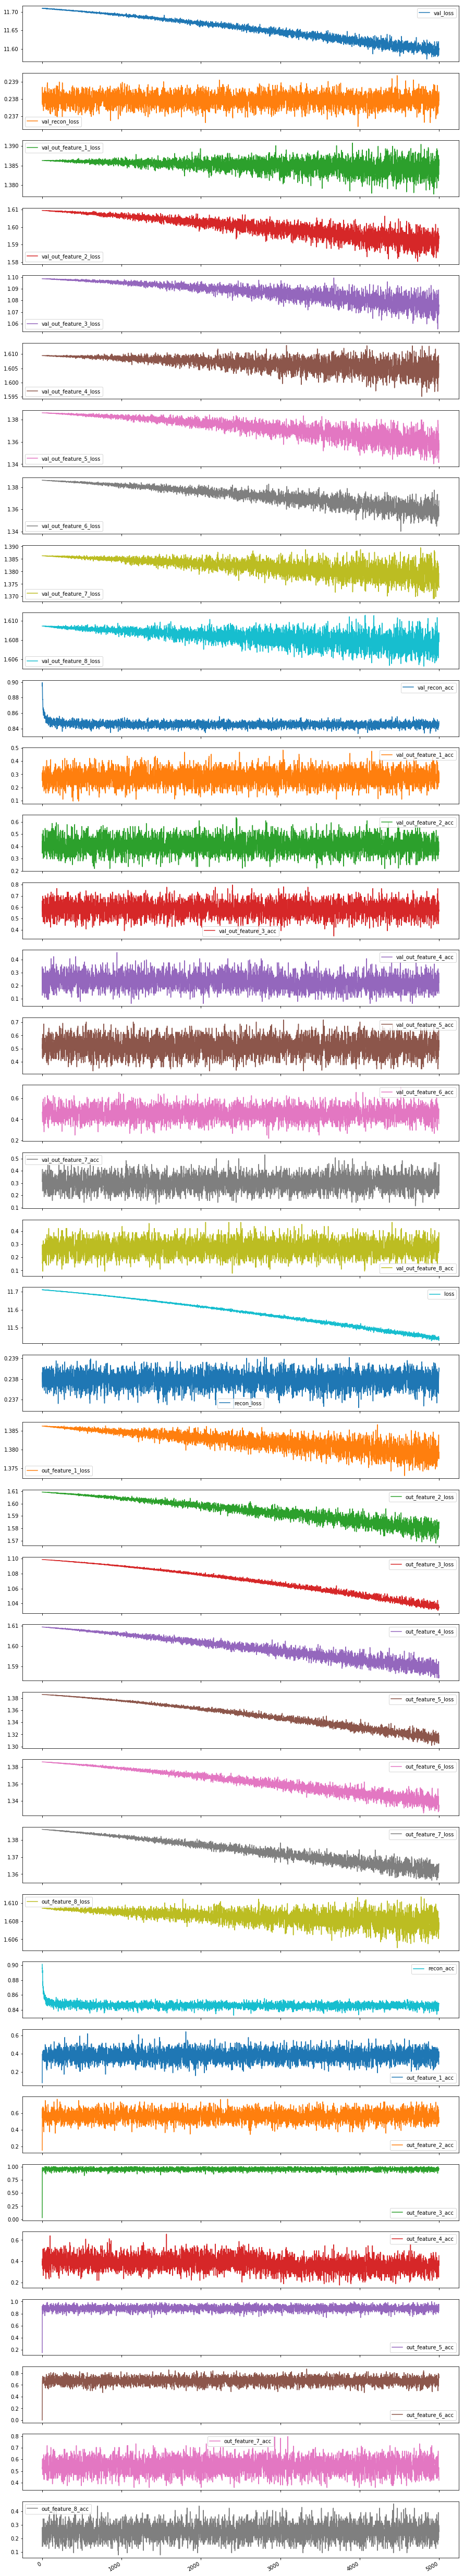

In [18]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,100))
print(df_hist['val_loss'].min())
df_hist[df_hist['val_loss']<10.2]

In [19]:
# print(df_hist.columns)
print(df_hist['val_out_feature_1_acc'].max(), df_hist['val_out_feature_2_acc'].max(),
       df_hist['val_out_feature_3_acc'].max(), df_hist['val_out_feature_4_acc'].max(),
       df_hist['val_out_feature_5_acc'].max(), df_hist['val_out_feature_6_acc'].max(),
       df_hist['val_out_feature_7_acc'].max(), df_hist['val_out_feature_8_acc'].max())
# df_hist[df_hist['val_acc']>10.2]

0.484375 0.6349206566810608 0.796875 0.453125 0.71875 0.703125 0.53125 0.46875


In [21]:
train_csv_data.var()


Unnamed: 0    40891.666667
f1                0.851443
f2                1.531445
f3                0.045492
f4                1.736920
f5                0.344204
f6                0.345686
f7                0.781598
f8                1.696078
f9                0.119540
dtype: float64

In [22]:
val_csv_data.var()

Unnamed: 0    8883.500000
f1               1.056461
f2               1.782312
f3               0.377348
f4               1.635451
f5               0.991638
f6               0.637669
f7               1.083200
f8               1.550618
f9               0.240491
dtype: float64